# Module: Illumination correction by order consistency

Based on the paper "Illumination Compensation Based Change Detection Using Order Consistency"
by Parameswaran V, Singh M, Ramesh V.

We are estimating a global illumination level and factors to get every image on that illumination level.

In [4]:
import glob
import numpy as np
import pickle
import cv2
import os
import pandas as pd
import collections
import matplotlib.pyplot as plt

We start by estimating the brightness for every image and choosing image with the median illumination as a target.

In [7]:
illuminations = {}
images = {}

for f in glob.glob("../data/cropped_plants/*.jpg"):
    img = cv2.imread(f)
    
    timestamp_s = os.path.basename(f).replace(".jpg", "")
    timestamp = pd.Timestamp(int(timestamp_s), unit="s")

    avg_illumination = img.mean().mean()

    # skip dark images or images taken during the evening / night / early morning
    if avg_illumination < 10 or not (10 <= timestamp.hour <= 16):
        continue

    images[f] = img
    illuminations[f] = avg_illumination

# choose the image with the median illumination
median_illumination_file = sorted(illuminations.items(), key=lambda tpl: tpl[1])[len(illuminations) // 2][0]
median_illumination_img = cv2.imread(median_illumination_file)

Next we generate the response function (which pixel intesity corresponds to which intensity intensity) curve and its inverse. For this, we take the response function from our database of response functions ([DoRF](https://www1.cs.columbia.edu/CAVE//software/softlib/dorf.php)).
In case we don't know the camera model or the camera model is not included, we take the average of all response functions.

In [9]:
def read_dorf_curve():
    #this function will generate a array
    # pixelIntensity [0-255] -> LightIntensity [0-1.0]
    dorf_file = "../data/dorfCurves.txt"
    with open(dorf_file) as f:
        lines = f.readlines()
        #starting from the 3rd, every 6th line is a response function, the other lines do not interest us
        response_functions_lines = lines[3::6]

    response_functions = [[float(num) for num in func.split("  ")] for func in response_functions_lines]
    average_response_function = np.array(response_functions).mean(axis=0)
    # the response function is given as 1024 values, as a 0.25 pixel intensity resolution
    # for our purposes, we just need the whole numbers, so every 4th value
    return average_response_function[::4]

def invert_response_curve(curve):
    # this function will generate a array
    # LightIntensity [0-1.0] -> pixelIntensity [0-255]
    # with a resoultion of 1000 elements between 0 and 1.0

    NUM_ELEMENTS = 1000
    inverted_curve = np.zeros((NUM_ELEMENTS + 1, ), dtype='uint16')
    last_entry = 0
    for i in range(NUM_ELEMENTS):
        target = i * 1 / NUM_ELEMENTS
        while curve[last_entry] <= target:
            if last_entry == len(curve) - 1:
                inverted_curve[i] = last_entry
                break
            else:
                last_entry += 1
        else:
            inverted_curve[i] = last_entry

    # make sure 1.0 maps to 255
    inverted_curve[NUM_ELEMENTS] = 255
    return inverted_curve

#these functions are just for vectorizing the array lookup via numpy
def look_up_response(x):
    return response_curve[x]
look_up_response = np.vectorize(look_up_response)

def inverted_look_up_response(x):
    return inverted_response_curve[round(x)]
inverted_look_up_response = np.vectorize(inverted_look_up_response)

response_curve = read_dorf_curve()
inverted_response_curve = invert_response_curve(response_curve)

Next we iterate over the cropped images and seperate the color. We then order each pixel intensity by number of occurrences.

In [10]:
illumination_ratios = {}
for name, img in images.items():
    name = os.path.basename(name)
    ratios = []
    for i in range(3):
        region = img[:, :, i]
        num_pixels = region.shape[0] * region.shape[1]
        region = region.reshape((num_pixels, 1))
        comparison_img = median_illumination_img.copy()
        comparison_region = comparison_img[:,:, i]
        comparison_region = comparison_region.reshape((num_pixels, 1))

        hist = collections.Counter(region[:, 0])
        comparison_hist = collections.Counter(comparison_region[:, 0])

        #there are too many pixels with 0 intensity, also this simplifies the calculation later on
        hist[0] = 0
        comparison_hist[0] = 0

        #make sure the most common intensities are the same length, drop rare intensities otherwise
        min_len = min(len(hist), len(comparison_hist)) // 2

        hist = hist.most_common(min_len)
        comparison_hist = comparison_hist.most_common(min_len)

        most_common_response = [look_up_response(x[0]) for x in sorted(hist, key=lambda tpl: tpl[0])]
        comparioson_most_common_response = [look_up_response(x[0]) for x in sorted(comparison_hist, key=lambda tpl: tpl[0])]

        illumination_ratio = sum([tpl[0] / tpl[1] for tpl in zip(most_common_response, comparioson_most_common_response)]) / len(hist)
        ratios.append(illumination_ratio)

    illumination_ratios[name] = ratios

Last step is storing the correction parameters for later use.

In [11]:
pickle.dump(illumination_ratios, open("illumination_correction.param", "wb"))

The actual correcting works by multiplying each color by the factor. We show one example image before and after illumination correction.

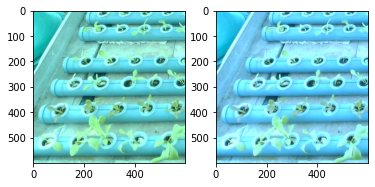

In [12]:
# if we use the calibration in another module, we have to load the illumination ratios again
illumination_ratios = pickle.load(open("illumination_correction.param", "rb"))

f = "../data/cropped_plants/1601031601.jpg"
img = cv2.imread(f)
original_img = img.copy()

color_factors = illumination_ratios[os.path.basename(f)]

# convert the pixel insensities into light intensities, multiply by a factor and convert back
img = look_up_response(img)
for i, color_factor in enumerate(color_factors):
    img[:, :, i] = img[:, :, i] * color_factor
img = img.clip(0, 1)
img = inverted_look_up_response((1000*img).astype("uint16"))

img = img.astype('uint8')

# convert  before showing
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_img)
ax2.imshow(img)
plt.draw()
